# 01. Dataset review

[COVID-19 Open Research Dataset (CORD-19)](https://pages.semanticscholar.org/coronavirus-research) is a free resource delivering over 44 000 papers, including over 29 000 full texts about COVID-19 and the coronavirus family of viruses for use by the global research community. The dataset contains the content of the articles, as well as some additional metadata. The idea is to give free access to all the people who are familiar with modern NLP techniques, in order to extract some useful insights that could help the society to understand better the causes, treatments and possible effects on the humanity.

There is a Kaggle [COVID-19 Open Research Dataset Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) that uses the dataset as a base for looking for the answers to a series of important questions about the current epidemy.

![SARS paper warning in 2007](images/sars-warning-2007.jpeg)

*Source: linkedin.com, Wilmar Igl*

## Problem definition

The number of papers on COVID-19 grows so fast that nobody can really follow them all and be up to date with the latest outcomes. Due to that, having a tool which allows to quickly search for the relevant papers, might be great for the researchers, but also to all the people who are interested in anything related to the pandemic. The main problem is to find a way to easily compare the given question to the papers' content, in order to find the ones that answer it. We can expect the papers to be written in a formal language, using some domain-specific words and phrases, and without the prior knowledge of the subject, we cannot really express our thought with exactly the same form as the researchers did. That's where modern NLP methods comes to the rescue.

## Loading the dataset

The full schema of the dataset can be easily found on the website. In general, it is divided into 4 subsets depending on the license of the paper, and each article is put in a separate JSON file. The main unit of the text is a single paragraph, so if we want to have the whole text together, we need to make a little preprocessing. For the simplicity, we are going to put the articles in a flat structure, a DataFrame, so the paper identifier, its title, abstract, body text and license are going to be our columns and each row is going to represent a single article. However, we are also going to keep the paragraphs, as they are quite well-suited to the problem of encoding the meaning. Finally, we are going to have two different DataFrames then.

First of all, let's combine all the file paths into a single list, to allow reading them quickly.

In [3]:
from typing import List

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import logging
import glob
import json
import sys
import os

In [5]:
logger = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

In [6]:
input_dirs = [
    "/data/cord19/comm_use_subset", 
    "/data/cord19/biorxiv_medrxiv", 
    "/data/cord19/noncomm_use_subset",
    "/data/cord19/pmc_custom_license",
]

In [7]:
input_files = []
for input_dir in input_dirs:
    current_files = glob.glob(f"{input_dir}/*")
    logger.debug("Got %d articles from the directory %s",
                 len(current_files), input_dir)
    input_files = input_files + current_files
logger.info("Got %d articles overall", len(input_files))

INFO:__main__:Got 13202 articles overall


## Getting the paragraphs

We have already mentioned, the dataset uses paragraph as a basic unit for body text representation. We are also going to have one DataFrame, where the paragraphs will be stored, along with their position in the article and the identifier of the source paper.

In [8]:
paragraphs = []
for input_file in input_files:
    # Extract the directory name, as it defines
    # the license type for the article
    dirname = os.path.dirname(input_file)
    article_license = os.path.basename(dirname)
    
    # Process a single article file
    with open(input_file, "r") as fp:
        # Load JSON representation of an article
        doc = json.load(fp)
        
        # Combine all the paragraphs into single text
        for i, part in enumerate(doc["body_text"]):
            # Put the paragraph to the list of rows
            paragraph = [doc["paper_id"], i, part["text"], article_license]
            paragraphs.append(paragraph)

In [9]:
paragraphs_df = pd.DataFrame(
    paragraphs, columns=["paper_id", "paragraph_number", 
                         "paragraph_text", "paper_license"]
).set_index(["paper_id", "paragraph_number"])

In [10]:
paragraphs_df.sample(n=3)

,,paragraph_text,paper_license
paper_id,paragraph_number,,
46768e7c839a7f4de0d5a73d25897f948b4eac30,3,"During July-August 2015, the Ministry of Healt...",noncomm_use_subset
376ac2d5c7446918fdc12ef89696687b8a2b23d8,16,Irrespective of the overall common suppressive...,comm_use_subset
b30770ae30b35cdfaf0a173863e74e93edbb0329,381,In ischemic tissue extravascular volume will d...,comm_use_subset


In [11]:
paragraphs_df.shape

(412268, 2)

In [15]:
paragraphs_df.to_parquet("./data/paragraphs_df.parquet")

The dataset has over 400 000 paragraphs, and the histogram below shows the distribution of their lengths.

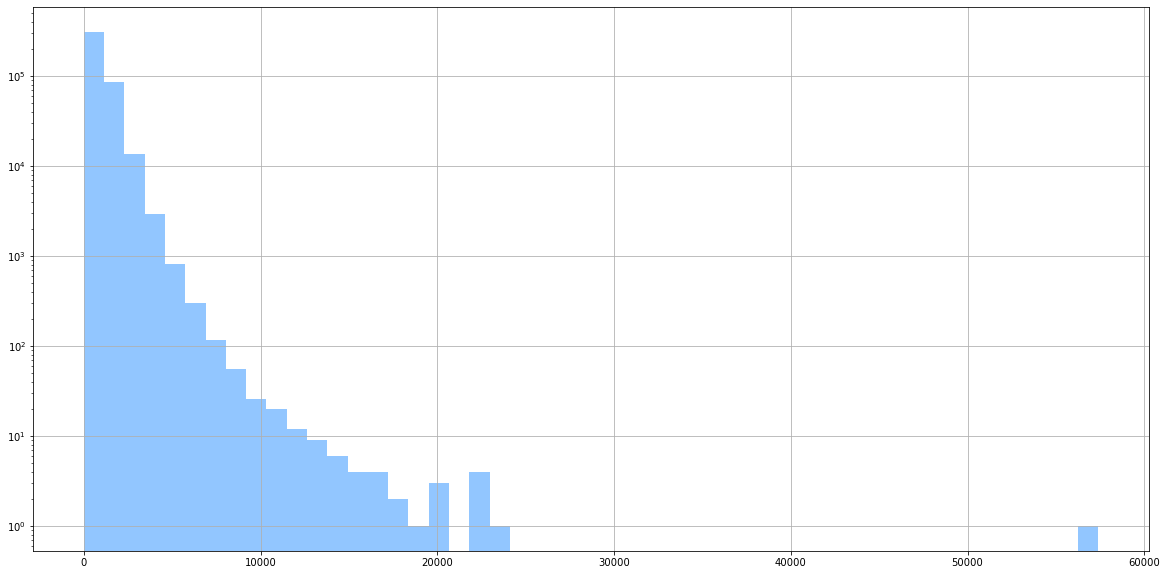

In [24]:
with plt.style.context("seaborn-pastel"):
    paragraphs_df["paragraph_text"].str.len() \
        .hist(figsize=(20, 10), bins=50, log=True)

The distribution of the word counts is also quite interesting, so it's presented on a histogram below. Please keep in mind, we used `.split` method to perform the tokenization, so the results might be different comparing to some more fancy algorithms.

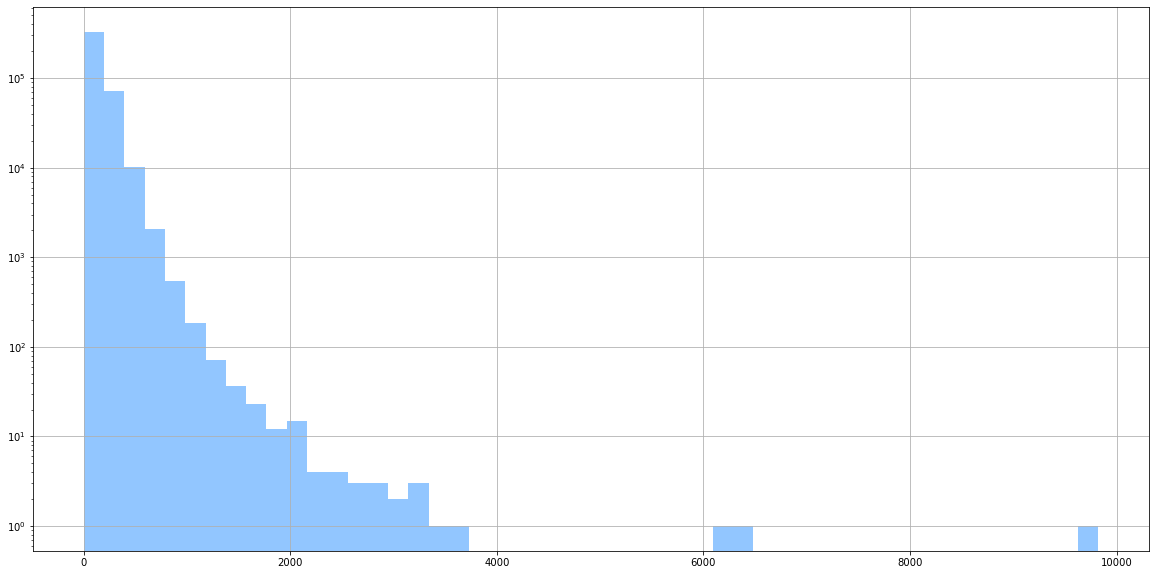

In [23]:
with plt.style.context("seaborn-pastel"):
    paragraphs_df["paragraph_text"].str.split() \
        .map(lambda x: len(x)) \
        .hist(figsize=(20, 10), bins=50, log=True)

## Getting the articles

The dataset of paragraphs has the paper identifier as one of the columns. That was done to avoid putting the title, abstract, etc. at paragraph level, due to high redundancy. Instead, we are going to get the paper details from a separate DataFrame, once the paragraph might be a proper answer to somebody's question.

In [26]:
def extract_full_text(doc_entry: List[dict]) -> str:
    return "\n".join((part["text"] for part in doc_entry))

In [27]:
articles = []
for input_file in input_files:
    # Extract the directory name, as it defines
    # the license type for the article
    dirname = os.path.dirname(input_file)
    article_license = os.path.basename(dirname)
    
    # Process a single article file
    with open(input_file, "r") as fp:
        # Load JSON representation of an article
        doc = json.load(fp)
        
        # Combine all the paragraphs into single text
        abstract = extract_full_text(doc["abstract"]).strip()
        body_text = extract_full_text(doc["body_text"]).strip()
        back_matter = extract_full_text(doc["back_matter"]).strip()
        
        # Correct, if abstract is a part of body text, as then
        # the body text typically starts with a lowercase letter
        if body_text[0].islower():
            body_text = f"{abstract} {body_text}"
        
        # Put the article to the list of rows
        article = [doc["paper_id"], doc["metadata"]["title"],
                   abstract, body_text, 
                   back_matter, article_license]
        articles.append(article)

In [28]:
articles_df = pd.DataFrame(
    articles, columns=["paper_id", "title", 
                       "abstract", "body_text", 
                       "back_matter", "license"]
).set_index("paper_id")

In [29]:
articles_df.sample(n=5)

,title,abstract,body_text,back_matter,license
paper_id,,,,,
18aa7bfcf8b4dfcad03cf4836aaaa5345d6cfdc7,Citation: Molecular Therapy-Nucleic Acids (201...,Development of RNAi-based therapeutics has the...,RNA interference (RNAi) is a powerful approach...,Acknowledgments. We thank Wendy Baker and Prof...,noncomm_use_subset
69cf21ea0c191cb1ea580856df13fea7b1608b00,,Background: Acute lower respiratory tract infe...,(Continued from previous page) Discussion: If ...,We would like to acknowledge the role of Profe...,comm_use_subset
0d82c429737f250a7bcd230fea2e4725edc2439a,viruses The Interaction between Nidovirales an...,Autophagy is a conserved intracellular catabol...,Nidoviruses rank among the most complex RNA vi...,"Author Contributions: Y.C., P.V. and F.R. orga...",comm_use_subset
a735cd10efb7df82d87da350bc33e3ca3acab6ed,The risk of transmission of a viral haemorrhag...,,contaminated with splashes or droplets of blo...,"Microbiology and Biotechnology Unit, Health an...",comm_use_subset
cf12680358351109a975a23165bbb48620b578a5,Development of a recombinant replication- defi...,Middle East respiratory syndrome-coronavirus (...,Middle East respiratory syndrome (MERS) is a h...,We would like to thank Dr. Kazuo Ohnishi and M...,comm_use_subset


In [30]:
articles_df.shape

(13202, 5)

In [31]:
articles_df.to_parquet("./data/articles_df.parquet")

## Filtering the COVID-19 related papers

As described at the very beginning, the dataset has the papers not only about the COVID-19, but also about different species of coronaviruses. If we wanted to compare the current pandemic with some previous ones, than it might be kind of interesting, but as we are going to analyze the current understanding of the problem, let's limit the dataset to contain the articles about COVID-19 only.

In [32]:
covid_19_articles_df = articles_df[
    articles_df["body_text"].str.contains("SARS-CoV-2", case=False) |
    articles_df["body_text"].str.contains("COVID-19", case=False) |
    articles_df["body_text"].str.contains("2019-nCoV", case=False)
]

In [34]:
covid_19_articles_df.sample(n=3)

,title,abstract,body_text,back_matter,license
paper_id,,,,,
14783283da3482bf2aab4e6100fe4ea5c29d8db7,Original investigation Vicarious traumatizatio...,"Since December 2019, more than 79,000 people h...","Since December 2019, the outbreak of COVID-19 ...",,biorxiv_medrxiv
5585d267f9b505b068f9f72bff5f12c248472f0a,Epidemic size of novel coronavirus-infected pn...,"Background: Since late December 2019, novel co...","In the late December 2019, a pneumonia, now kn...",All rights reserved. No reuse allowed without ...,biorxiv_medrxiv
46634d03aa169aab9c372746ebaf3aaa65d7c7d9,Case fatality rate of novel coronavirus diseas...,Background: A pandemic of coronavirus disease ...,Background: A pandemic of coronavirus disease ...,to COVID-19 could be regarded as timely. The s...,biorxiv_medrxiv


In [33]:
covid_19_articles_df.shape

(560, 5)

In [19]:
covid_19_articles_df.to_parquet("./data/covid_19_articles_df.parquet")

## Target application

The main problem is how to encode the question to make it comparable with the paragraph content. Hopefully, the modern text vectorization methods would help us to solve that issue. For that reason, we are going to perform the following steps:

1. For each paragraph, prepare a vectorized representation of its content. 
2. When a user inputs a question, create the corresponding vector representation of it.
3. Find the N closest paragraph vectors to the question vector.